# <div style="color:white;display:fill;border-radius:5px;background-color:#2F4F4F;letter-spacing:0.5px;overflow:hidden\"><p style="padding:20px;color:white;overflow:hidden;text-align: center;margin:0;font-size:120%\">Deploy</h1></div>

# 0.0 Imports

In [42]:
import re
import os
import pickle
import inflection
import numpy   as np
import pandas  as pd
import datetime as dt
import seaborn as sns
import umap.umap_ as umap
import matplotlib.cm as cm
from matplotlib import pyplot as plt
from sklearn import cluster as c
from sklearn import metrics as m
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn.manifold import TSNE
from sklearn import ensemble as en
from sklearn import mixture  as mx
import scipy.cluster.hierarchy as hc
from sqlalchemy import create_engine


## 0.1 Helper Functions

In [44]:
def numerical_metrics(num_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(num_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(num_attributes.apply(np.std)).T
    d_min = pd.DataFrame(num_attributes.apply(min)).T
    d_max = pd.DataFrame(num_attributes.apply(max)).T
    d_range = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    #concat
    num_desc = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    num_desc.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']

    return num_desc

def cluster_label(x):
    cluster_labels = {
        0: 'Insiders',
        1: 'Loyal Customers',
        2: 'Potentials',
        3: 'Promising',
        8: 'Regular',
        9: 'Need Attention',
        7: 'At Risk',
        5: 'Sleeping',
        10: 'Hibernating',
        4: 'About to lose',
        6: 'Losing'
    }
    return cluster_labels.get(x)

## 0.2 Loading Data

In [45]:
# load data
df_raw = pd.read_csv( '../data/Ecommerce.csv', encoding= 'unicode_escape' )

# 1.0 Data Description

## 1.1 Rename Columns

In [46]:
df1 = df_raw.copy()

In [47]:
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, df1.columns))
df1.columns = cols_new

## 1.2 Data Dimension

In [48]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Columns: {}'.format( df1.shape[1] ) )

Number of Rows: 541909
Number of Columns: 9


## 1.3 Check NA

In [49]:
null_values = pd.DataFrame({'NA Count' : df1.isna().sum(), '% NA' : (df1.isna().sum()) / (df1.shape[0]) * (100)})
null_values

,NA Count,% NA
invoice_no,0,0.000000
stock_code,0,0.000000
description,1454,0.268311
quantity,0,0.000000
invoice_date,0,0.000000
unit_price,0,0.000000
customer_id,135080,24.926694
country,0,0.000000
unnamed: 8,541909,100.000000


## 1.4 Fillout NA

In [50]:
# drop NA column
df1 = df1.drop('unnamed: 8', axis=1)

# remove NA
df1 = df1.dropna( subset=['customer_id'] )

print( 'Removed data: {:.2f}%'.format( 1 - (df1.shape[0] / df_raw.shape[0]) ) )

Removed data: 0.25%


## 1.5 Change dtypes

In [51]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [52]:
# invoice_date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype( 'int64' )

## 1.6 Data Descriptive

In [53]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.6.1 Numerical attributes

In [54]:
numerical_metrics(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


### 1.6.2 Categorical attributes

In [14]:
# invoice number - feature com string e int
df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

print( 'Number of invoices: {}'.format( len(df_letter_invoices) ) )
print( 'Total number of negative quantity: {}'.format( len(df_letter_invoices['quantity'] <= 0 ) ) )

Number of invoices: 8905
Total number of negative quantity: 8905


In [15]:
# stock code - feature c string
cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: bool( re.search( '^[a-zA-Z]+$', x ) ) ), 'stock_code'].unique()

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

# 2.0 Data Filtering

In [16]:
df2 = df1.copy()

In [17]:
# numerical attributes
df2 = df2.loc[df2['unit_price'] >= 0.04, : ]

# categorical attributes
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']) ]

# description/country
df2 = df2.drop(columns=['description', 'country'])

# drop duplicate
df2.drop_duplicates(inplace=True)

# bad users
# [16446, 12346, 15749]
bad_users = [17548, 16546, 15823, 13672, 12346, 13762, 16446, 17900, 18268, 14557, 16878, 13364, 14792, 12607, 12454, 18274, 12558]
df2 = df2[~df2['customer_id'].isin( bad_users )]

# quantity
df2_returns = df2.loc[df1['quantity'] < 0, :]
df2_purchases = df2.loc[df1['quantity'] >= 0, :]

# 3.0 Feature Engeneering

In [18]:
df3 = df2.copy()

In [19]:
df_ref = df3['customer_id'].drop_duplicates().reset_index(drop=True)

In [20]:
# Gross revenue
df2_purchases = df2_purchases.assign(gross_revenue=df2_purchases['quantity'] * df2_purchases['unit_price'])

In [21]:
# Invoice 
df3_invoice = df2_purchases.groupby('invoice_no').agg(  customer_id = ('customer_id', 'max'), 
                                                        invoice_date = ('invoice_date', 'max'), 
                                                        gross_revenue = ('gross_revenue', 'sum'),
                                                        unique_products = ('stock_code', 'nunique'),
                                                        items = ('quantity', 'sum') ).reset_index()

In [22]:
# Customer

last_day = df2_purchases.invoice_date.max() + dt.timedelta(days = 1)

df_customer = df3_invoice.groupby('customer_id').agg(   gross_revenue = ('gross_revenue', 'sum'),                                           
                                                        recency = ('invoice_date', lambda x: ((last_day - x.max()).days)),       
                                                        frequency = ('invoice_no', 'count'),
                                                        items = ('items', 'sum'),
                                                        products = ('unique_products', 'sum') ).reset_index()

In [23]:
df_customer.head()

,customer_id,gross_revenue,recency,frequency,items,products
0,12347,4310.00,3,7,2458,182
1,12348,1437.24,76,4,2332,23
2,12349,1457.55,19,1,630,72
3,12350,294.40,311,1,196,16
4,12352,1385.74,37,7,526,77


In [24]:
# returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename(columns={'quantity': 'returns'} )
df_returns['returns'] = df_returns['returns'] * -1


In [25]:
# merge - customer 
df_ref = pd.merge( df_ref, df_customer, on='customer_id', how='left')

# merge - returns
df_ref = pd.merge( df_ref, df_returns, on='customer_id', how='left' )
df_ref.loc[df_ref['returns'].isna(), 'returns'] = 0
df_ref.isna().sum()


customer_id       0
gross_revenue    27
recency          27
frequency        27
items            27
products         27
returns           0
dtype: int64

In [26]:
df_ref = df_ref.dropna()
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency          0
frequency        0
items            0
products         0
returns          0
dtype: int64

In [27]:
df_ref.head()

,customer_id,gross_revenue,recency,frequency,items,products,returns
0,17850,5391.21,373.0,34.0,1733.0,297.0,37.0
1,13047,3232.59,57.0,9.0,1390.0,171.0,35.0
2,12583,6705.38,3.0,15.0,5028.0,232.0,50.0
3,13748,948.25,96.0,5.0,439.0,28.0,0.0
4,15100,876.00,334.0,3.0,80.0,3.0,22.0


# 4.0 EDA (Exploratory Data Analysis)

In [28]:
df4 = df_ref.copy()

# 5.0 Feature Selection

In [29]:
# selected dataset
cols_selected = ['gross_revenue', 'recency', 'frequency', 'products', 'returns' ]
df5 = df4[cols_selected].copy()

# 6.0 Data Preparation

In [30]:
df6 = df5.copy()

In [31]:
mm = pp.MinMaxScaler()


df6['gross_revenue'] = mm.fit_transform( df6[['gross_revenue']] )
# pickle.dump(mm, open( '../src/features/gross_revenue_scaler.pkl', 'wb' ) )

df6['recency']  =      mm.fit_transform( df6[['recency']] )
# pickle.dump(mm, open( '../src/features/recency_scaler.pkl', 'wb' ) )

df6['frequency'] =     mm.fit_transform( df6[['frequency']] )
# pickle.dump(mm, open( '../src/features/frequency_scaler.pkl', 'wb' ) )

df6['products'] =      mm.fit_transform( df6[['products']] )
# pickle.dump(mm, open( '../src/features/products_scaler.pkl', 'wb' ) )

df6['returns'] =       mm.fit_transform( df6[['returns']] )
# pickle.dump(mm, open( '../src/features/returns_scaler.pkl', 'wb' ) )

X = df6.copy()

## 6.1 Dimensonality Reduction

### 6.1.1 PCA

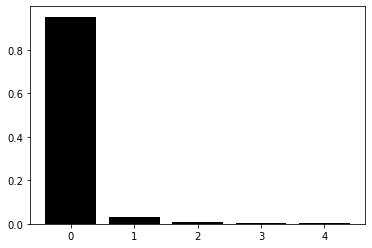

In [32]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

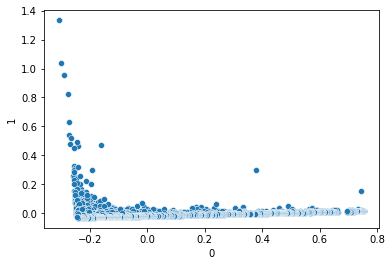

In [34]:
sns.scatterplot( x=0, y=1, data=df_pca );

### 6.1.2 UMAP

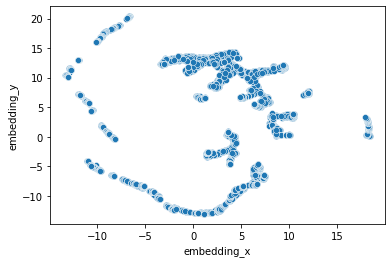

In [35]:
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_umap = pd.DataFrame()
df_umap['embedding_x'] = embedding[:, 0]
df_umap['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_umap );

### 6.1.3 - T-SNE

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


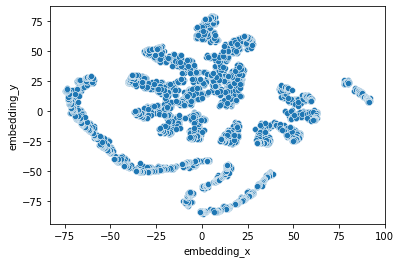

In [36]:
reducer = TSNE( n_components=2, n_jobs=-1, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_tsne = pd.DataFrame()
df_tsne['embedding_x'] = embedding[:, 0]
df_tsne['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tsne );

### 6.1.4 Tree-based Embedding

In [37]:
# training dataset
X = df6.drop( columns=['gross_revenue'], axis=1 )

# defining target
y = df6['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor( n_estimators=100, min_samples_split=32, n_jobs=-1, random_state=42 )


# model training
rf_model.fit( X, y )

# pickle.dump( rf_model, open('../src/models/rf_model.pkl', 'wb' ) )

# leafs
df_leaf = pd.DataFrame( rf_model.apply( X ) )

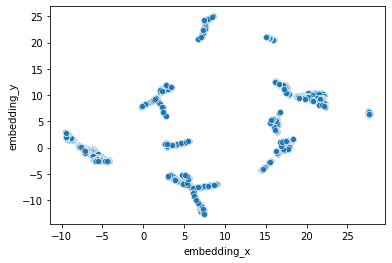

In [38]:
# reduce dimensionality
reducer = umap.UMAP( n_neighbors=100, random_state=42) 
embedding = reducer.fit_transform( df_leaf )

# pickle.dump( reducer, open( '../src/features/umap_reducer.pkl', 'wb'))

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', data=df_tree );

# 7.0  Hyperparameter Fine Tunning

In [ ]:
X = df_tree.copy()
# X = df_umap.copy()
# X = df_tsne.copy()

In [ ]:
clusters = np.arange( 2, 16 ,1)

## 7.1 Models

In [ ]:
kmeans_list = []
gmm_list = []
hc_list = []

for k in clusters:
    
    # kmeans
    kmeans_model = c.KMeans(n_clusters=k, n_init=100, random_state=42)
    kmeans_labels = kmeans_model.fit_predict(X)
    kmeans_sil = m.silhouette_score(X, kmeans_labels, metric='euclidean')
    kmeans_list.append(kmeans_sil)

    # GMM
    gmm_model = mx.GaussianMixture(n_components=k, n_init=10, random_state=42)
    gmm_labels = gmm_model.fit_predict(X)    
    gmm_sil = m.silhouette_score(X, gmm_labels, metric='euclidean')
    gmm_list.append(gmm_sil)

    # HC
    hc_model = hc.linkage( X, 'ward' )
    hc_labels = hc.fcluster( hc_model, k, criterion='maxclust' )
    hc_sil = m.silhouette_score(X, hc_labels, metric='euclidean')
    hc_list.append(hc_sil)     

In [ ]:
dbs_list = []
eps = np.arange(1, 2.5, 0.11)

for k in eps:
    dbs_model = c.DBSCAN(eps=k, min_samples=20, metric='euclidean')
    dbs_labels = dbs_model.fit_predict(X)   
    dbs_sil = m.silhouette_score(X, dbs_labels, metric='euclidean')
    dbs_list.append(dbs_sil) 

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
fig.suptitle("Model Performance\n\n", fontweight='bold', fontsize=18)

axes[0].plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
axes[0].set_title("Kmeans", fontsize=13)
axes[0].set_ylabel('Silhouette Score', fontsize=14)
axes[0].set_xlabel('Number of Clusters (K)')

axes[1].plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
axes[1].set_title("GMM", fontsize=13)
axes[1].set_xlabel('Number of Clusters (K)')

axes[2].plot(clusters, hc_list, linestyle='--', marker='o', color='b')
axes[2].set_title("Hierarchical Clustering", fontsize=13)
axes[2].set_xlabel('Number of Clusters (K)')

axes[3].plot(eps, dbs_list, linestyle='--', marker='o', color='b')
axes[3].set_title("DBScan", fontsize=13)
axes[3].set_xlabel('EPS')

plt.show()

## 7.2 Results

In [ ]:
df_results = pd.DataFrame( {'KMeans': kmeans_list, 
                            'GMM': gmm_list,
                            'HC': hc_list,
                            'DBSCAN': dbs_list }).T
df_results.columns = clusters
df_results.style.highlight_max( color='green', axis=1 )

# 8.0  Model Training

In [ ]:
dbs_model = c.DBSCAN(eps=1.3, min_samples=20, metric='euclidean')
dbs_labels = dbs_model.fit_predict(X)   
print( 'SS value: {}'.format( m.silhouette_score( X, dbs_labels, metric='euclidean' ) ) )

# 9.0 Cluster Analysis

In [ ]:
df9 = X.copy()
df9['cluster'] = dbs_labels
df9.head()

## 9.1. Visualization Inspection

In [ ]:
sns.scatterplot( x='embedding_x', y='embedding_y', hue='cluster', data=df9, palette='deep');

## 9.2 Cluster profile

In [ ]:
df92 = df4.copy()
df92['cluster'] = dbs_labels
df92.head()

In [ ]:
df_cluster = df92.groupby('cluster').agg({  'customer_id': 'count',
                                            'gross_revenue': 'mean',
                                            'recency': 'mean',
                                            'frequency': 'mean',
                                            'items': 'mean',
                                            'products': 'mean',
                                            'returns': 'mean'}).reset_index()

df_cluster['perc_customer'] = 100 * (df_cluster['customer_id'] / df_cluster['customer_id'].sum())

df_cluster = df_cluster.sort_values('gross_revenue', ascending=False)
df_cluster

In [ ]:
# rename clusters
df_cluster['cluster'] = df_cluster['cluster'].apply(cluster_label)
df_cluster.sort_values('gross_revenue', ascending=False)

# 10.0 Deploy

In [ ]:
df92.dtypes

In [ ]:
df92['recency'] = df92['recency'].astype( 'int64' )
df92['frequency'] = df92['frequency'].astype( 'int64' )
df92['items'] = df92['items'].astype( 'int64' )
df92['products'] = df92['products'].astype( 'int64' )
df92['returns'] = df92['returns'].astype( 'int64' )

In [ ]:
df92.head()

In [ ]:
# database connection
conn = create_engine("sqlite:///../src/sqlite/insiders_db.sqlite")

# # drop table
# # query_drop = """
# #         DROP TABLE insiders

# # """

# # create table
# query_create = """

#         CREATE TABLE insiders (
#             customer_id     INTEGER,
#             gross_revenue   REAL,
#             recency         INTEGER,
#             frequency       INTEGER,
#             items           INTEGER,
#             products        INTEGER,
#             returns         INTEGER,
#             cluster         INTEGER
#         )

# """

# conn.execute(query_create)

In [ ]:
df92.to_sql('insiders', con=conn, if_exists='append', index=False)

In [ ]:
query = """
        SELECT * FROM insiders
"""
df = pd.read_sql_query(query, conn)
df.head()